**Title**

Predicting the real price of a two person private room for a Parisian Airbnb rental on a weekday

**Introduction**

- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

Airbnb is an online service that connects hosts with properties, to travelers that are interested in renting for short term homestays.The host of the home is the determinant of the price, but will set it according to an array of factors, such as location, view, cleaning service fee etc. For our report, we are interested in whether particular factors, such as the type of room being offered, the capacity of the rental, distance to the city center, and to the nearest metro station, influence the price, and if so, in what way. This will be that question we will try to answer, and using these factors, we will attempt to predict the price of a private room Airbnb rental in our city of choice, being Paris, on any given weekday. 

According to Jones (2023), particularly the factors of public transportation and city centre play a great deal in convenience when it comes to travel, Paul Swiney, writer at the Guardian, even stating that proximity to the city centre drives up renting costs, given the higher productivity and economic activity associated within the city (Swinney, 2011). 


In order to see the relationship between these variables and the price of the rental, the dataset we will be analyzing is paris_weekdays.csv from Airbnb Prices in European Cities posted on https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities?resource=download&select=paris_weekdays.csv. The dataset is a .csv file with 3129 observations and 20 vector variables. We will be using 4 of the variables to make our predictions: dist, metro_dist, person_capacity, and room_type will be used to predict realSum (the price). All the variables are double (dbl) except room_type, which is a character (chr).


**Methods & Results**

- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
- note: all tables and figure should have a figure/table number and a legend

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
paris_dataset <- read_csv("https://raw.githubusercontent.com/chadsc79/dsci-100-2022w2-group-7-section-005/main/paris_weekdays.csv")
paris_dataset

New names:
• `` -> `...1`
Rows: 3130 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,296.1599,Private room,FALSE,TRUE,2,TRUE,0,0,10,97,1,0.6998206,0.1937094,518.4789,25.23938,1218.6622,71.60803,2.35385,48.86282
1,288.2375,Private room,FALSE,TRUE,2,TRUE,0,0,10,97,1,2.1000054,0.1072207,873.2170,42.50791,1000.5433,58.79146,2.32436,48.85902
2,211.3431,Private room,FALSE,TRUE,2,FALSE,0,0,10,94,1,3.3023251,0.2347238,444.5561,21.64084,902.8545,53.05131,2.31714,48.87475
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3127,567.8535,Entire home/apt,FALSE,FALSE,6,TRUE,0,0,10,96,3,4.312136,0.3046418,178.2228,8.675825,420.7262,24.72168,2.39334,48.88463
3128,200.3915,Entire home/apt,FALSE,FALSE,2,TRUE,0,0,9,93,1,2.891206,0.2406864,235.1685,11.447924,602.4515,35.39977,2.38200,48.87400
3129,301.2862,Entire home/apt,FALSE,FALSE,2,FALSE,0,0,10,92,1,3.469721,0.5084927,200.6395,9.767062,478.9928,28.14540,2.39992,48.85886


In [3]:
#select variables to predict the data and filter for private room
paris_clean_dataset <- select(paris_dataset, dist, metro_dist, person_capacity, room_type, realSum)|>
filter(room_type == "Private room") |>
filter(person_capacity == 2)
paris_clean_dataset

dist,metro_dist,person_capacity,room_type,realSum
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.6998206,0.1937094,2,Private room,296.1599
2.1000054,0.1072207,2,Private room,288.2375
3.3023251,0.2347238,2,Private room,211.3431
⋮,⋮,⋮,⋮,⋮
4.232441,0.09317788,2,Private room,213.6732
4.170402,0.01023344,2,Private room,136.0798
2.687260,0.22577602,2,Private room,151.6917


In [4]:
#find the min/max of the training dataset
options(digits= 4)
min_max_prices <- summarize(paris_clean_dataset,
          minimum_price = min(realSum),
          maximum_price = max(realSum))
min_max_prices

minimum_price,maximum_price
<dbl>,<dbl>
117.2,1170


In [5]:
#create price ranges to be predicted with the training set
paris_clean_dataset$price_range <- cut(paris_clean_dataset$realSum, breaks = c(0, 200, 500, 1000,2000, 15000))
paris_clean_dataset

dist,metro_dist,person_capacity,room_type,realSum,price_range
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>
0.6998,0.1937,2,Private room,296.2,"(200,500]"
2.1000,0.1072,2,Private room,288.2,"(200,500]"
3.3023,0.2347,2,Private room,211.3,"(200,500]"
⋮,⋮,⋮,⋮,⋮,⋮
4.232,0.09318,2,Private room,213.7,"(200,500]"
4.170,0.01023,2,Private room,136.1,"(0,200]"
2.687,0.22578,2,Private room,151.7,"(0,200]"


In [6]:
#find the training set average of each variable
options(digits=4)
summarized_paris_dataset <- summarize(paris_clean_dataset,
                                      avg_dist = mean(dist),
                                      avg_metro_dist = mean(metro_dist),
                                      avg_price = mean(realSum))
summarized_paris_dataset

avg_dist,avg_metro_dist,avg_price
<dbl>,<dbl>,<dbl>
3.205,0.2294,274


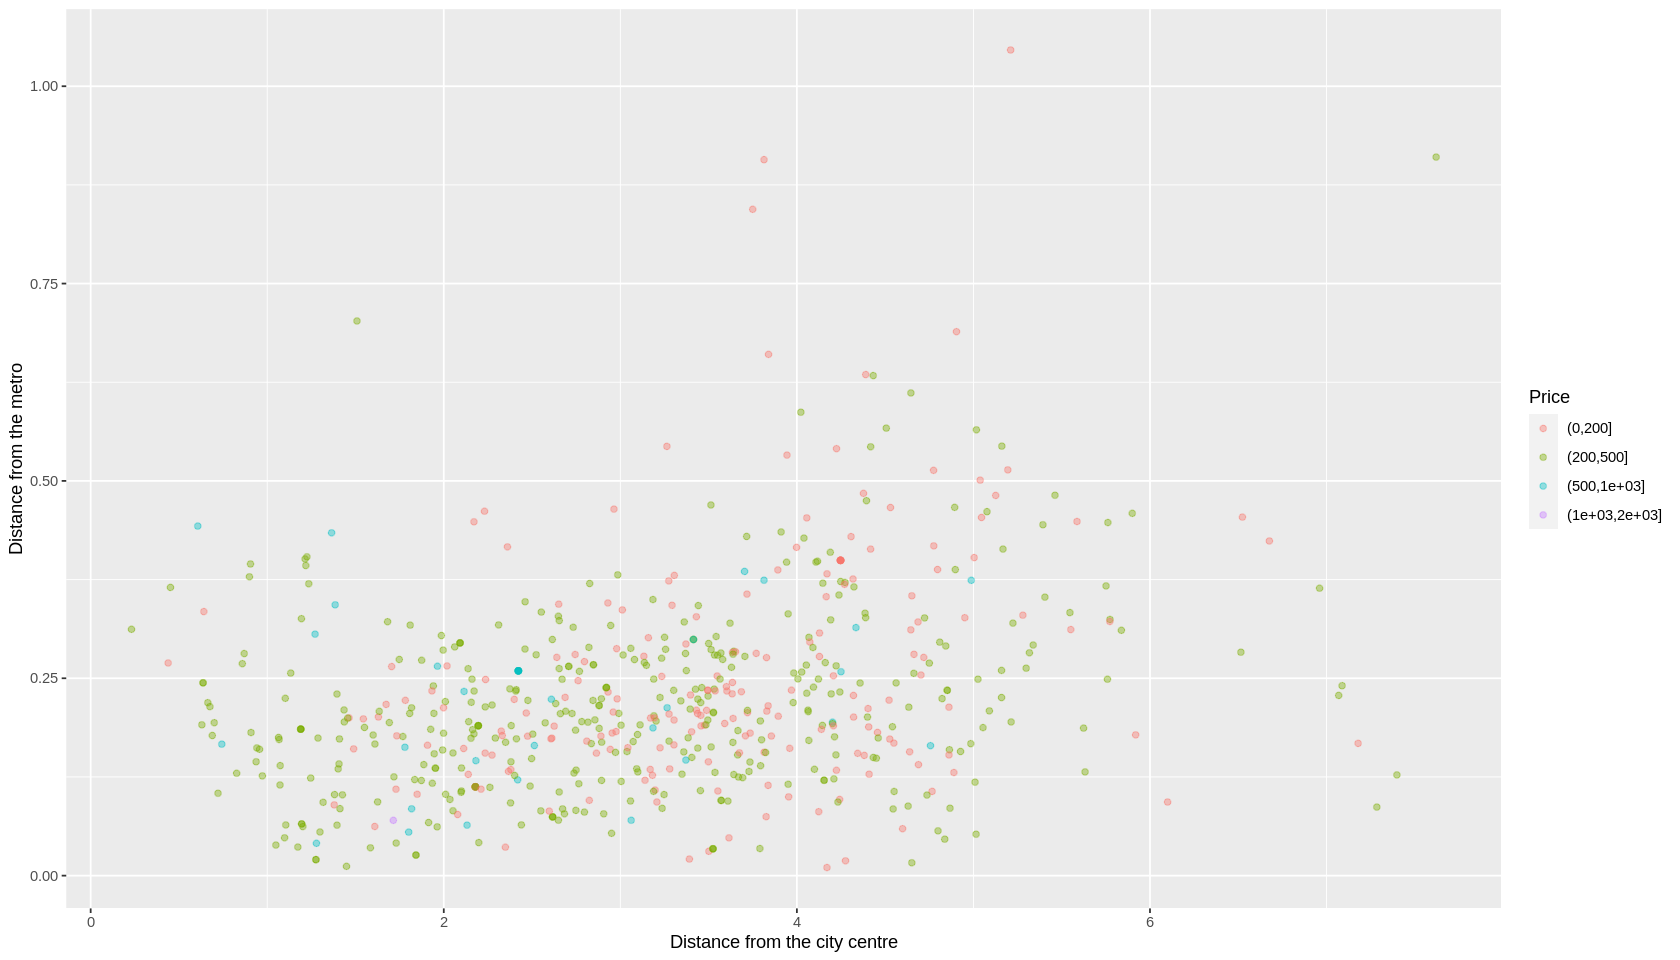

In [7]:
#scatterplot of distance from the city centre and distance from the metro for private room types for private rooms, categorized by price
options(repr.plot.width = 14, repr.plot.height = 8)
dataset_visual <- paris_clean_dataset|>
ggplot( aes(x = dist, y = metro_dist, color = price_range))+
geom_point(alpha = 0.4) +
labs(x = "Distance from the city centre", y = "Distance from the metro", color = "Price")
dataset_visual

The graph above is plotting the distance from the city centre on the x-axis against the distance from the metro in the y-axis, and we are using the price range as a factor to differentiate the points to see whether the air bnb available with particular conditions falls in a cheaper price range or not. Here we can see the points in the lower left corner have the most favourable conditions according to a general person. These points have the least distance from transportation and the city centre. 

In [8]:
#split the data into a testing set and a training set
set.seed(250)

paris_split <- initial_split(paris_clean_dataset, prop = .80, strata = price_range)  
paris_train <- training(paris_split) 

paris_test <- testing(paris_split)
paris_train

dist,metro_dist,person_capacity,room_type,realSum,price_range
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>
3.998,0.4158,2,Private room,193.6,"(0,200]"
2.115,0.2333,2,Private room,868.9,"(500,1e+03]"
1.490,0.1606,2,Private room,173.4,"(0,200]"
⋮,⋮,⋮,⋮,⋮,⋮
3.794,0.13921,2,Private room,238.8,"(200,500]"
3.791,0.03430,2,Private room,278.2,"(200,500]"
4.232,0.09318,2,Private room,213.7,"(200,500]"


! Fold01: internal:
  No observations were detected in `truth` for level(s): '(1e+03,2e+03]'...
  Computation will proceed by ignoring those levels.

! Fold02: internal:
  No observations were detected in `truth` for level(s): '(1e+03,2e+03]'...
  Computation will proceed by ignoring those levels.

! Fold03: internal:
  No observations were detected in `truth` for level(s): '(1e+03,2e+03]'...
  Computation will proceed by ignoring those levels.

! Fold04: internal:
  No observations were detected in `truth` for level(s): '(1e+03,2e+03]'...
  Computation will proceed by ignoring those levels.

! Fold05: internal:
  No observations were detected in `truth` for level(s): '(1e+03,2e+03]'...
  Computation will proceed by ignoring those levels.

! Fold06: internal:
  No observations were detected in `truth` for level(s): '(1e+03,2e+03]'...
  Computation will proceed by ignoring those levels.

! Fold07: internal:
  No observations were detected in `truth` for level(s): '(1e+03,2e+03]'...
  Co

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5508,10,0.01919,Preprocessor1_Model01
1,roc_auc,hand_till,0.5485,10,0.02632,Preprocessor1_Model01
3,accuracy,multiclass,0.5407,10,0.01489,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
37,roc_auc,hand_till,0.5680,10,0.03143,Preprocessor1_Model19
39,accuracy,multiclass,0.6144,10,0.01498,Preprocessor1_Model20
39,roc_auc,hand_till,0.5730,10,0.02964,Preprocessor1_Model20


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.5508,10,0.01919,Preprocessor1_Model01
3,accuracy,multiclass,0.5407,10,0.01489,Preprocessor1_Model02
5,accuracy,multiclass,0.5777,10,0.01758,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,accuracy,multiclass,0.6260,10,0.01431,Preprocessor1_Model18
37,accuracy,multiclass,0.6260,10,0.01556,Preprocessor1_Model19
39,accuracy,multiclass,0.6144,10,0.01498,Preprocessor1_Model20


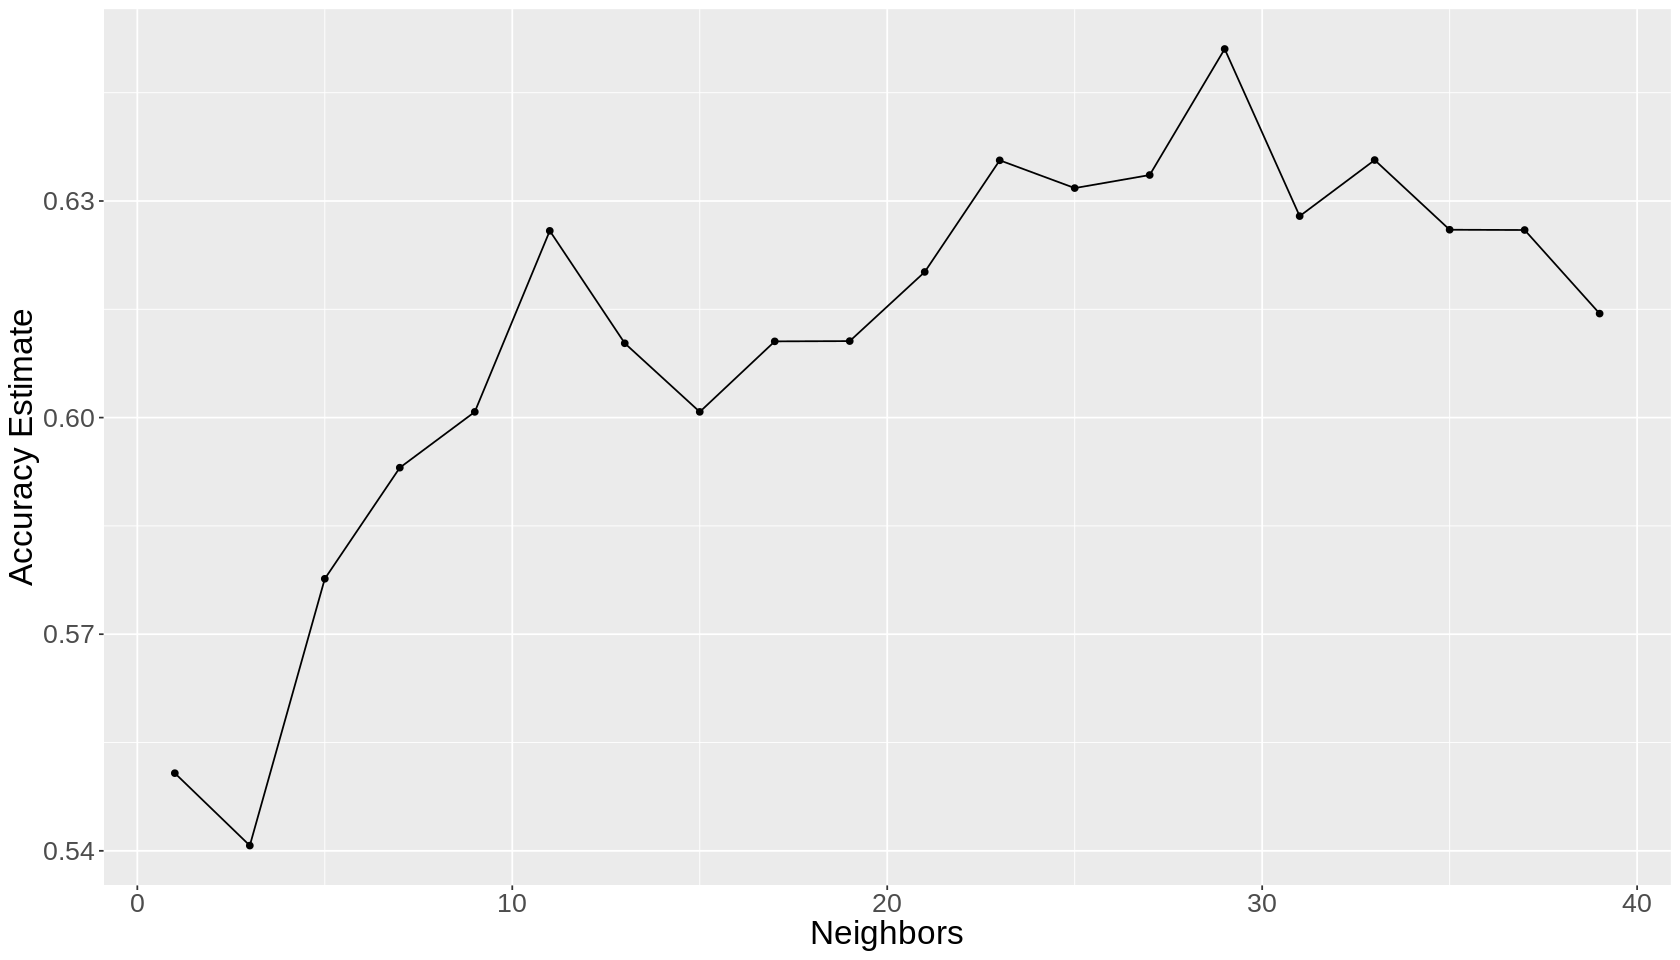

In [9]:
#pre-process the data
paris_recipe <- recipe(price_range ~ dist + metro_dist, data = paris_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

#tune classifier
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
         set_engine("kknn") |>  
         set_mode("classification")

#create a tibble for the k values
k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

#making a v-fold
paris_vfold <- vfold_cv(paris_train, v = 10, strata = price_range)

#creating a workflow and labels
knn_results <- workflow() |>
  add_recipe(paris_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = paris_vfold, grid = k_vals) |>
  collect_metrics()
knn_results

#Calculating accuracies
accuracies <- knn_results |>
  filter(.metric == "accuracy") 

accuracies


# Plot of k values against their respective accuracies
cross_val_plot <- accuracies |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))

cross_val_plot

In [10]:

knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
  set_engine("kknn") |>
  set_mode("classification")

paris_fit <- workflow() |>
  add_recipe(paris_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = paris_train)
  

# Get the prediction column
paris_predictions <- predict(paris_fit, paris_test) |> 
    bind_cols(paris_test)
paris_predictions

# Compare the accuracy of predictions to the true values in the test set
paris_acc <- paris_predictions |> 
    metrics(truth = price_range, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
paris_acc

.pred_class,dist,metro_dist,person_capacity,room_type,realSum,price_range
<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>
"(200,500]",0.6998,0.1937,2,Private room,296.2,"(200,500]"
"(200,500]",0.6755,0.2141,2,Private room,242.8,"(200,500]"
"(200,500]",1.0735,0.1394,2,Private room,242.8,"(200,500]"
⋮,⋮,⋮,⋮,⋮,⋮,⋮
"(200,500]",3.675,0.15557,2,Private room,139.3,"(0,200]"
"(0,200]",4.247,0.39935,2,Private room,127.2,"(0,200]"
"(200,500]",4.170,0.01023,2,Private room,136.1,"(0,200]"


.metric,.estimate
<chr>,<dbl>
accuracy,0.5659


**Discussion**

*- summarize what you found*

We found that no matter what k-value we used, the accuracy was low. 

*- discuss whether this is what you expected to find?*

We expected to find that private room rentals with a two person capacacity that are closer to the city centre and are closer to the metro will be more expensive than ones that are farther away. 

*- discuss what impact could such findings have?*

Any impacts from this study will help Airbnb hosts determine the private room price that they charge for their rental based on the criteria we used in the study. And it will help renters gauge how much to expect to pay when they are staying in areas that are similar to those in the study.

*- discuss what future questions could this lead to?*

Our findings could lead to questions such as:

Are there better predictors of price for an Airbnb that were not used, such as cleanliness rating and overall guest satisfaction?
Do these findings also occur in other Airbnb cities?
Is there a difference in price for Airbnb rentals in urban areas compared to rural areas using the same criteria?
Do the same criteria apply to weekend rentals as well as weekday rentals?

**References**

- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.

Jones, R. (2022, October 3). How to find the best location for your next Airbnb - AirHost Academy. AirHost Academy - The Airbnb Host Blog for Tips and Secrets. Retrieved April 9, 2023, from https://airhostacademy.com/how-to-find-the-best-location-for-your-next-airbnb/ 

Swinney, P. (2011, November 9). Statsblog: What role do city centres play in local economic growth? The Guardian. Retrieved April 9, 2023, from https://www.theguardian.com/local-government-network/statsblog/2011/nov/09/statsblog-role-of-city-centres 